In [1]:
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import torch
import torch.nn as nn
import torch.nn.functional
import torchvision
from torch.utils.data import TensorDataset
import math

In [2]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image/255.
    return image

def load_data(root_path, size):
    images = []
    masks = []
    x = 0
    for path in sorted(glob(root_path)):
        img = load_image(path, size)
        if 'mask' in path:
            if x:
                masks[-1] += img
                masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1
        else:
            images.append(img)
            x = 0
    return np.array(images), np.array(masks)

In [14]:
size = 224
X, Y = load_data('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/*', size)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, shuffle=True)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size=0.5,shuffle=True)
X_train.shape, X_valid.shape, X_test.shape, Y_train.shape, Y_valid.shape, Y_test.shape

((147, 224, 224),
 (31, 224, 224),
 (32, 224, 224),
 (147, 224, 224),
 (31, 224, 224),
 (32, 224, 224))

In [15]:
'''
Note always use pytorch transforms alongside dataloaders for image augmentation.
This is a crude way of doing thing.
'''

X_train = np.expand_dims(X_train,-1)
Y_train = np.expand_dims(Y_train,-1)

def elastic_transform(image, mask, alpha_affine):

    random_state = np.random.RandomState(None)
    shape = image.shape
    shape_size = shape[:2]

    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = 42#min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
    mask = cv2.warpAffine(mask, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
    return image, mask

def hflip_transform(image, mask):
    image = cv2.flip(image, 1)
    mask = cv2.flip(mask, 1)
    return image, mask

def vflip_transform(image, mask):
    image = cv2.flip(image, 0)
    mask = cv2.flip(mask, 0)
    return image, mask

def flip_transform(image, mask):
    image = cv2.flip(image, -1)
    mask = cv2.flip(mask, -1)
    return image, mask

el_train_images = [elastic_transform(img, mask, img.shape[1] * 0.04) for img,mask in zip(X_train,Y_train )]

hflip_train_images = [hflip_transform(img, mask) for img,mask in zip(X_train,Y_train )]

vflip_train_images = [vflip_transform(img, mask) for img,mask in zip(X_train,Y_train )]

flip_train_images = [flip_transform(img, mask) for img,mask in zip(X_train,Y_train )]


train_images_list = [el_train_images, hflip_train_images, vflip_train_images, flip_train_images]


for each_el_tf in train_images_list:
    el_tf_imgs,  el_tf_masks = zip(*each_el_tf)
    el_tf_imgs = list(el_tf_imgs)
    el_tf_masks = list(el_tf_masks)
    X_train = np.concatenate((X_train, np.expand_dims(el_tf_imgs, -1)))
    Y_train = np.concatenate((Y_train, np.expand_dims(el_tf_masks, -1)))

X_train = torch.from_numpy(np.float32(np.squeeze(X_train,-1))).unsqueeze(1)
Y_train = torch.from_numpy(np.float32(np.squeeze(Y_train,-1))).unsqueeze(1)
X_valid = torch.from_numpy(np.float32(X_valid)).unsqueeze(1)
Y_valid = torch.from_numpy(np.float32(Y_valid)).unsqueeze(1)
X_test = torch.from_numpy(np.float32(X_test)).unsqueeze(1)
Y_test = torch.from_numpy(np.float32(Y_test)).unsqueeze(1)
X_train.shape, X_valid.shape, X_test.shape, Y_train.shape, Y_valid.shape, Y_test.shape

(torch.Size([735, 1, 224, 224]),
 torch.Size([31, 1, 224, 224]),
 torch.Size([32, 1, 224, 224]),
 torch.Size([735, 1, 224, 224]),
 torch.Size([31, 1, 224, 224]),
 torch.Size([32, 1, 224, 224]))

In [17]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(TensorDataset(X_train,Y_train), batch_size=BATCH_SIZE,
                                        shuffle=True)

valid_loader = torch.utils.data.DataLoader(TensorDataset(X_valid,Y_valid), batch_size=BATCH_SIZE,
                                        shuffle=True)

test_loader = torch.utils.data.DataLoader(TensorDataset(X_test,Y_test), batch_size=BATCH_SIZE,
                                        shuffle=True)

In [18]:
def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size[0], window_size[0], W // window_size[1], window_size[1], C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0], window_size[1], C)
    return windows

def window_reverse(windows, window_size, H, W):
    C = windows.shape[-1]
    x = windows.view(-1, H // window_size[0], W // window_size[1], window_size[0], window_size[1], C)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, H, W, C)
    return x

def get_relative_position_index(win_h: int, win_w: int):
    # get pair-wise relative position index for each token inside the window
    coords = torch.stack(torch.meshgrid(torch.arange(win_h), torch.arange(win_w),indexing='ij'))  # 2, Wh, Ww
    coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
    relative_coords[:, :, 0] += win_h - 1  # shift to start from 0
    relative_coords[:, :, 1] += win_w - 1
    relative_coords[:, :, 0] *= 2 * win_w - 1
    return relative_coords.sum(-1)  # Wh*Ww, Wh*Ww

class WindowAttention(nn.Module):
    def __init__(
            self,
            dim,
            window_size,
    ):
        super().__init__()
        self.window_size = window_size
        self.window_area = self.window_size[0]*self.window_size[1]
        self.num_heads = 4
        head_dim =  dim // self.num_heads
        # attn_dim = head_dim * self.num_heads
        self.scale = head_dim ** -0.5

        self.relative_position_bias_table = nn.Parameter(torch.zeros((2 * window_size[0] - 1) **2, self.num_heads))

        # get pair-wise relative position index for each token inside the window
        self.register_buffer("relative_position_index", get_relative_position_index(self.window_size[0], self.window_size[1]), persistent=False)

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

        torch.nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def _get_rel_pos_bias(self):
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)].view(self.window_area, self.window_area, -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        return relative_position_bias.unsqueeze(0)

    def forward(self, x, mask = None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)


        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn + self._get_rel_pos_bias()
        if mask is not None:
            num_win = mask.shape[0]
            attn = attn.view(-1, num_win, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
        attn = self.softmax(attn)
        x = attn @ v

        x = x.transpose(1, 2).reshape(B_, N, -1)
        x = self.proj(x)
        return x

In [19]:
class SwinTransformerBlock(nn.Module):
    def __init__(
            self,  dim, input_resolution, window_size = 7, shift_size = 0):

        super().__init__()
        self.input_resolution = input_resolution
        window_size = (window_size, window_size)
        shift_size = (shift_size, shift_size)
        self.window_size = window_size
        self.shift_size = shift_size
        self.window_area = self.window_size[0] * self.window_size[1]

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(
            dim,
            window_size=self.window_size,
        )

        self.norm2 = nn.LayerNorm(dim)

        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.LayerNorm(4 * dim),
            nn.Linear( 4 * dim, dim)
        )

        if self.shift_size:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            H = math.ceil(H / self.window_size[0]) * self.window_size[0]
            W = math.ceil(W / self.window_size[1]) * self.window_size[1]
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            cnt = 0
            for h in (
                    slice(0, -self.window_size[0]),
                    slice(-self.window_size[0], -self.shift_size[0]),
                    slice(-self.shift_size[0], None)):
                for w in (
                        slice(0, -self.window_size[1]),
                        slice(-self.window_size[1], -self.shift_size[1]),
                        slice(-self.shift_size[1], None)):
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_area)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask, persistent=False)

    def _attn(self, x):
        B, H, W, C = x.shape

        # cyclic shift
        if self.shift_size:
            shifted_x = torch.roll(x, shifts=(-self.shift_size[0], -self.shift_size[1]), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_area, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size[0], self.window_size[1], C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
        shifted_x = shifted_x[:, :H, :W, :].contiguous()

        # reverse cyclic shift
        if self.shift_size:
            x = torch.roll(shifted_x, shifts=self.shift_size, dims=(1, 2))
        else:
            x = shifted_x
        return x

    def forward(self, x):
        B, H, W, C = x.shape
        B, H, W, C = x.shape
        x = x + self._attn(self.norm1(x))
        x = x.reshape(B, -1, C)
        x = x + self.mlp(self.norm2(x))
        x = x.reshape(B, H,W, C)
        return x

In [20]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_ch, num_feat, patch_size):
        super().__init__()
        self.conv = nn.Conv2d(in_ch,num_feat, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).permute(0,2,3,1)

class PatchMerging(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(4 * dim)
        self.reduction = nn.Linear(4*dim, 2*dim, bias=False)

    def forward(self, x):
        B, H, W, C = x.shape
        x = x.reshape(B, H // 2, 2, W // 2, 2, C).permute(0, 1, 3, 4, 2, 5).flatten(3)
        x = self.norm(x)
        x = self.reduction(x)
        return x

class PatchExpansion(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(dim//2)
        self.expand = nn.Linear(dim, 2*dim, bias=False)

    def forward(self, x):

        x = self.expand(x)
        B, H, W, C = x.shape

        x = x.view(B, H , W, 2, 2, C//4)
        x = x.permute(0,1,3,2,4,5)

        x = x.reshape(B,H*2, W*2 , C//4)

        x = self.norm(x)
        return x

class FinalPatchExpansion(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.expand = nn.Linear(dim, 16*dim, bias=False)

    def forward(self, x):

        x = self.expand(x)
        B, H, W, C = x.shape

        x = x.view(B, H , W, 4, 4, C//16)
        x = x.permute(0,1,3,2,4,5)

        x = x.reshape(B,H*4, W*4 , C//16)

        x = self.norm(x)
        return x

In [21]:
class SwinBlock(nn.Module):
    def __init__(self, dims, ip_res, ss_size = 3):
        super().__init__()
        self.swtb1 = SwinTransformerBlock(dim=dims, input_resolution=ip_res)
        self.swtb2 = SwinTransformerBlock(dim=dims, input_resolution=ip_res, shift_size=ss_size)

    def forward(self, x):
        return self.swtb2(self.swtb1(x))


class Encoder(nn.Module):
    def __init__(self, C, partioned_ip_res, num_blocks=3):
        super().__init__()
        H,W = partioned_ip_res[0], partioned_ip_res[1]
        self.enc_swin_blocks = nn.ModuleList([
            SwinBlock(C, (H, W)),
            SwinBlock(2*C, (H//2, W//2)),
            SwinBlock(4*C, (H//4, W//4))
        ])
        self.enc_patch_merge_blocks = nn.ModuleList([
            PatchMerging(C),
            PatchMerging(2*C),
            PatchMerging(4*C)
        ])

    def forward(self, x):
        skip_conn_ftrs = []
        for swin_block,patch_merger in zip(self.enc_swin_blocks, self.enc_patch_merge_blocks):
            x = swin_block(x)
            skip_conn_ftrs.append(x)
            x = patch_merger(x)
        return x, skip_conn_ftrs


class Decoder(nn.Module):
    def __init__(self, C, partioned_ip_res, num_blocks=3):
        super().__init__()
        H,W = partioned_ip_res[0], partioned_ip_res[1]
        self.dec_swin_blocks = nn.ModuleList([
            SwinBlock(4*C, (H//4, W//4)),
            SwinBlock(2*C, (H//2, W//2)),
            SwinBlock(C, (H, W))
        ])
        self.dec_patch_expand_blocks = nn.ModuleList([
            PatchExpansion(8*C),
            PatchExpansion(4*C),
            PatchExpansion(2*C)
        ])
        self.skip_conn_concat = nn.ModuleList([
            nn.Linear(8*C, 4*C),
            nn.Linear(4*C, 2*C),
            nn.Linear(2*C, 1*C)
        ])

    def forward(self, x, encoder_features):
        for patch_expand,swin_block, enc_ftr, linear_concatter in zip(self.dec_patch_expand_blocks, self.dec_swin_blocks, encoder_features,self.skip_conn_concat):
            x = patch_expand(x)
            x = torch.cat([x, enc_ftr], dim=-1)
            x = linear_concatter(x)
            x = swin_block(x)
        return x


class SwinUNet(nn.Module):
    def __init__(self, H, W, ch, C, num_class, num_blocks=3, patch_size = 4):
        super().__init__()
        self.patch_embed = PatchEmbedding(ch, C, patch_size)
        self.encoder = Encoder(C, (H//patch_size, W//patch_size),num_blocks)
        self.bottleneck = SwinBlock(C*(2**num_blocks), (H//(patch_size* (2**num_blocks)), W//(patch_size* (2**num_blocks))))
        self.decoder = Decoder(C, (H//patch_size, W//patch_size),num_blocks)
        self.final_expansion = FinalPatchExpansion(C)
        self.head        = nn.Conv2d(C, num_class, 1,padding='same')

    def forward(self, x):
        x = self.patch_embed(x)

        x,skip_ftrs  = self.encoder(x)

        x = self.bottleneck(x)

        x = self.decoder(x, skip_ftrs[::-1])

        x = self.final_expansion(x)

        x = self.head(x.permute(0,3,1,2))

        return x

In [22]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinUNet(224,224,1,32,1,3,4).to(DEVICE)

for p in model.parameters():
    if p.dim() > 1:
            nn.init.kaiming_uniform_(p)

optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCEWithLogitsLoss()

def train_epoch(model, dataloader):
    model.train()
    losses= []
    for x, y in dataloader:
        optimizer.zero_grad()
        out = model.forward(x.to(DEVICE))
        loss = loss_fn(out, y.to(DEVICE)).to(DEVICE)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)
def validate_epoch(model, dataloader):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in dataloader:
            out = model.forward(x.to(DEVICE))
            loss = loss_fn(out, y.to(DEVICE)).to(DEVICE)
            losses.append(loss.item())
    return np.mean(losses)
def train(model, epochs, min_epochs, early_stop_count):

    best_valid_loss = float('inf')
    EARLY_STOP = early_stop_count
    for ep in range(epochs):
        train_loss = train_epoch(model, train_loader)
        valid_loss = validate_epoch(model, valid_loader)

        print(f'Epoch: {ep}: train_loss={train_loss:.5f}, valid_loss={valid_loss:.5f}')
        if ep>min_epochs:
            if(valid_loss < best_valid_loss):
                best_valid_loss = valid_loss
                EARLY_STOP = early_stop_count
            else:
                EARLY_STOP -= 1
                if EARLY_STOP <= 0:
                    return train_loss, valid_loss
    return train_loss, valid_loss

In [23]:
train(model, epochs=100, min_epochs=25, early_stop_count=5)

Epoch: 0: train_loss=0.46858, valid_loss=0.37863
Epoch: 1: train_loss=0.42363, valid_loss=0.37600
Epoch: 2: train_loss=0.41377, valid_loss=0.36319
Epoch: 3: train_loss=0.38896, valid_loss=0.32280
Epoch: 4: train_loss=0.36974, valid_loss=0.31471
Epoch: 5: train_loss=0.32574, valid_loss=0.28228
Epoch: 6: train_loss=0.29820, valid_loss=0.26852
Epoch: 7: train_loss=0.28345, valid_loss=0.24634
Epoch: 8: train_loss=0.24799, valid_loss=0.23700
Epoch: 9: train_loss=0.24375, valid_loss=0.29177
Epoch: 10: train_loss=0.22880, valid_loss=0.27741
Epoch: 11: train_loss=0.21477, valid_loss=0.27668
Epoch: 12: train_loss=0.21273, valid_loss=0.23371
Epoch: 13: train_loss=0.18729, valid_loss=0.25409
Epoch: 14: train_loss=0.17779, valid_loss=0.28336
Epoch: 15: train_loss=0.17083, valid_loss=0.25445
Epoch: 16: train_loss=0.16672, valid_loss=0.25887
Epoch: 17: train_loss=0.15862, valid_loss=0.28441
Epoch: 18: train_loss=0.15023, valid_loss=0.28801
Epoch: 19: train_loss=0.17224, valid_loss=0.23532
Epoch: 20:

(0.08228039028851883, 0.31402555108070374)

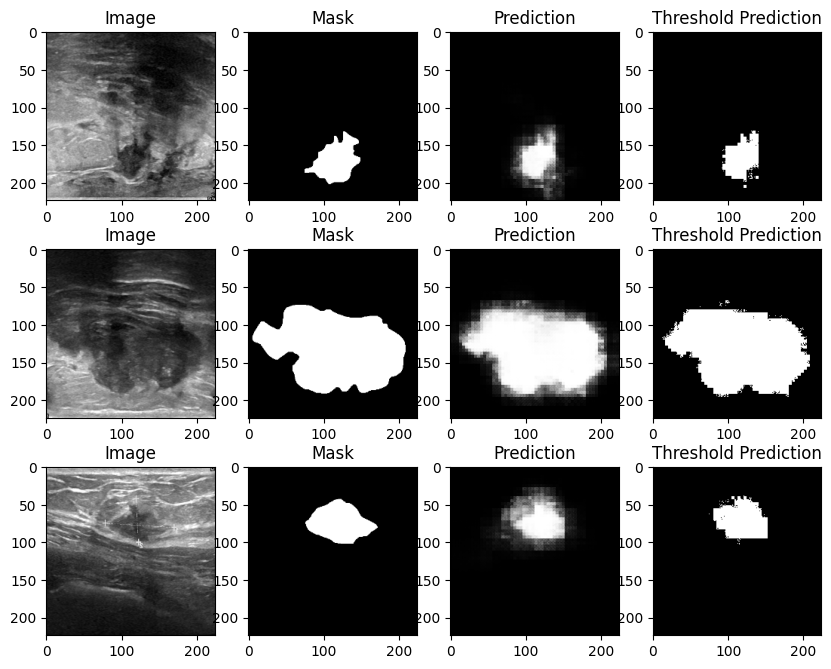

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,4, figsize=(10,8))
with torch.no_grad():
    for i in range(3):
        x_og,y_og = next(iter(train_loader))
        x = x_og[0]
        y = y_og[0]
        ax[i,0].imshow(x.squeeze(0).squeeze(0), cmap='gray')
        ax[i,0].set_title('Image')
        ax[i,1].imshow(y.squeeze(0).squeeze(0), cmap='gray')
        ax[i,1].set_title('Mask')
        x_og = x_og.to(DEVICE)
        out = model(x_og[:1])
        out = nn.Sigmoid()(out)
        out = out.squeeze(0).squeeze(0).cpu()
        ax[i,2].imshow(out, cmap='gray')
        ax[i,2].set_title('Prediction')
        ax[i,3].imshow((out>0.5).float(), cmap='gray')
        ax[i,3].set_title('Threshold Prediction')
plt.show()